<a href="https://colab.research.google.com/github/Vladimirsp81/DLS_2/blob/master/HW_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### **Домашнее задание**
В этом задании вам предстоит обучить свой собственный классификатор биологического гендера человека по аудиозаписи (спектрограмме). На [семинаре](https://vk.cc/atRKR8) 9 мая мы разобрали, как построить спектрограмму и подать ее в нейросеть, а также написали бейзлайн решение на Keras. 

### Задание 1 (20% баллов)
Взяв данные с семинара из датасета TIMIT (библиотека для работы с ним и подготовки данных также есть в семинаре) натренировать сетку так, чтобы на тестовой выборке accuracy_score был больше 0.97. Возможные исследования: conv1d vs conv2d, batch norm, предобученные сетки из `Imagenet`. Обязательно напишите, что вы использовали и какой вывод. Писать можно на любом фреймворке. 
### Задание 2 (30% баллов)
Подумайте, как бы можно было "испортить" данные для тестовой выборки и впоследствии попробовать восстановить скор при помощи аугментаций трейнсета и усложнения архитектуры? Используя данные из `TEST` усложните выборку и посмотрите, как упадет accuracy_score. Следите, чтобы он не падал ниже 70 -- есть риск тогда не обучиться совсем. Вдохновиться аудио аугментациями можно например [здесь](https://vk.cc/atRLgR). Почитать про то, как еще аугментируют данные, но уже на уровне спектрограмм можно [в блоге Google AI](https://vk.cc/9jCCnk). Посмотрите, какие аугментации влияют сильнее всего? На этом этапе мы пока ничего не учим, а только пытаемся испортить скор бейзлайна с семинара.
### Задание 3 (40% баллов)
При помощи изложенных в предыдущем пункте средств, а также идей и хинтов с семинара, постарайтесь улучшить скор модели на "испорченных" данных. Можно делать все, кроме обучения на тесте :). 
### Задание 4 (10% баллов)
Напишите вывод -- если попробовали какие-то архитектуры, аугментации, но это не помогло, тоже обязательно напишите. Расскажите, что пробовали, и что оказалось самым боевым. Здесь будет релевантно сделать таблицу.

Дополнительные материалы и ссылки:
1. [Текстом про то, как делается преобразование в мел-спектрограмму](https://medium.com/@jonathan_hui/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9)
2. [Соревнование по классификации голосовых команд](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)
3. [Данные для распознавания речи на русском языке](https://github.com/snakers4/open_stt)
4. [Проект по генерации музыки](https://openai.com/blog/jukebox/)
5. [Опенсорс-проект по разделению песни на минус и вокал](https://github.com/deezer/spleeter)
6. [wav2vec](https://arxiv.org/abs/1904.05862)
7. [Лекция 
Microsoft Research
 про историю Automatic Speech Recognition](https://www.youtube.com/watch?v=q67z7PTGRi8)
8. [Transformer для генерации музыки](https://openai.com/blog/musenet/)
9. [Библиотека, содержащая в себе api для распознавания речи (Google, Microsoft, ...)](https://pypi.org/project/SpeechRecognition/)

In [0]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm, tqdm_notebook
import joblib as jl
import os

import matplotlib.pyplot as plt
import IPython # прослушивание аудио в ноутбуке
import numpy as np # отсюда возьмем Фурье
import librosa # множественные манипуляции с аудиофайлами 
# import keras, keras.layers

%matplotlib inline

import torch
from sklearn.metrics import accuracy_score
plt.style.use('fivethirtyeight')

In [0]:
! wget https://audio-previews.elements.envatousercontent.com/files/6319559/preview.mp3 -O sample_f.mp3
! wget https://audio-previews.elements.envatousercontent.com/files/256324900/preview.mp3 -O sample_m.mp3

--2020-06-09 21:12:06--  https://audio-previews.elements.envatousercontent.com/files/6319559/preview.mp3
Resolving audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)... 13.225.2.62, 13.225.2.104, 13.225.2.129, ...
Connecting to audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)|13.225.2.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28202 (28K) [audio/mpeg]
Saving to: ‘sample_f.mp3’

sample_f.mp3        100%[===================>]  27.54K  --.-KB/s    in 0.001s  

2020-06-09 21:12:06 (32.1 MB/s) - ‘sample_f.mp3’ saved [28202/28202]

--2020-06-09 21:12:08--  https://audio-previews.elements.envatousercontent.com/files/256324900/preview.mp3
Resolving audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)... 13.225.2.94, 13.225.2.129, 13.225.2.62, ...
Connecting to audio-previews.elements.envatousercontent.com (audio-previews.elements.env

In [0]:
!apt-get install -y ffmpeg # Библиотека для обработки аудио

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
!ffmpeg -i sample_m.mp3 -ar 22050 -ac 1 sample_m.wav

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [0]:
IPython.display.Audio(librosa.load('sample_f.wav')[0], rate = 22050)

Построим график амплитуд

37440 points, 1.6979591836734693 sec, sr 22050


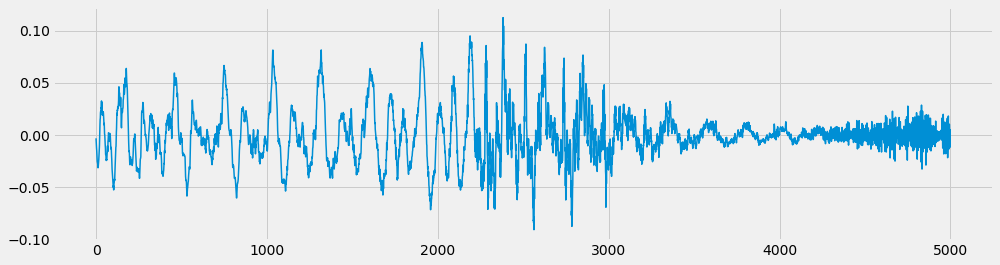

In [0]:
amplitudes, sample_rate = librosa.load("sample_m.wav")
print(f"{len(amplitudes)} points, {len(amplitudes) / sample_rate} sec, sr {sample_rate}")
plt.figure(figsize=[15, 4])
plt.title('')
plt.plot(amplitudes[20000:25000],linewidth=1.5)

Разделяем вход на пересекающиеся фреймы

In [0]:
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # выход: [window_length, num_windows]

Применяем к каждому фрейму преобразование Фурье

In [0]:
def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # разбиваем амплитуды на пересекающиеся фреймы [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)
    
    # получаем веса для Фурье, float[window_length]
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    # применяем преобразование Фурье
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft

Переводим полученную спектрограмму в мел-пространство

In [0]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes]
    :param sample rate: число отсчетов каждую секунду
    :param n_mels: число каналов спектрограммы
    :param window_length: параметр размера окна для Фурье
    :param hop_length: размер пересечения 
    :param f_min: мин частота
    :param f_max: макс частота
    :returns: мел-scaled спектрограмма [n_mels, duration]
    """
    # Шаг 1
    stft = get_STFT(amplitudes, window_length, hop_length)
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // 512 + 1)
    
    # Шаг 2
    spectrogram = np.abs(stft ** 2)
    
    # Шаг 3
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # ^-- matrix [n_mels, window_length / 2 + 1]
    
    mel_spectrogram = np.dot(mel_basis, spectrogram)
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // 512 + 1)
    
    return mel_spectrogram

In [0]:
amplitudes1, _  = librosa.load('sample_m.wav') # Считываем амплитуды
amplitudes2, _  = librosa.load('sample_f.wav')

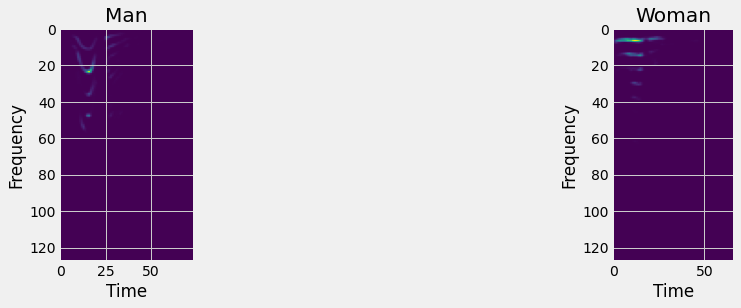

In [0]:
plt.figure(figsize=[16, 4])
plt.subplot(1, 2, 1)
plt.title("Man"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes1))

plt.subplot(1, 2, 2)
plt.title("Woman"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes2));

Проверяем правильность, полученных с помощью нашей функции, спектрограмм. Сравниваем с методом получения спектрограмм из librosa.

In [0]:
ref1 = librosa.feature.melspectrogram(amplitudes2, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
assert np.allclose(get_melspectrogram(amplitudes2), ref1, rtol=1e-4, atol=1e-4)

In [0]:
((ref1-get_melspectrogram(amplitudes2)) **2).mean() # Посмотрим на MSE

4.717526497791717e-13

Скачиваем dataset

In [0]:
!wget https://ndownloader.figshare.com/files/10256148

--2020-06-09 21:13:41--  https://ndownloader.figshare.com/files/10256148
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 18.203.1.140, 34.243.191.39, 34.247.146.8, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|18.203.1.140|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip [following]
--2020-06-09 21:13:42--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.105.74
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.105.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440207227 (420M) [binary/octet-stream]
Saving to: ‘10256148.1’

10256148.1          100%[===================>] 419.81M  10.4MB/s    in 43s     

2020-06-09 21:14:27 (9.78 MB/s) - ‘10256148.1’ saved [440207227/440207227]



In [0]:
!unzip -q 10256148

replace data/lisa/data/timit/raw/TIMIT/DOC/PROMPTS.TXT? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
!pip install timit-utils # Библиотека для работы с датасетами формата TIMIT

In [0]:
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

DATA_PATH = 'data/lisa/data/timit/raw/TIMIT'

# Создаем класс, который загружает и парсит информацию о спикерах
class Speaker:

  def __init__(self, data_path):
    self.doc_file_path = os.path.join(data_path, 'DOC','SPKRINFO.TXT')
    with open(self.doc_file_path) as f:
      self.id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])

  def return_sex(self, id):
    return self.id_sex_dict[id]

Speakers_info = Speaker(DATA_PATH)

In [0]:
# Для проверки функций
corpus = tu.Corpus(DATA_PATH)
person_1 = corpus.train.person_by_index(100)

In [0]:
# Обработаем данные
def preprocess_sample(amplitudes, gender, sr=16000, max_length=150):
    spectrogram = get_melspectrogram(amplitudes, sample_rate=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = 0 if gender == 'F' else 1
    return np.float32(spectrogram), np.int64(target)
    
tmp_1 = preprocess_sample(person_1.sentence_by_index(1).raw_audio, Speakers_info.return_sex(person_1.name))[0]
tmp_2 = librosa.feature.melspectrogram(person_1.sentence_by_index(1).raw_audio, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
assert np.allclose(get_melspectrogram(amplitudes2), ref1, rtol=1e-4, atol=1e-4)

Создадим тестсет и трейнсет из данных для TIMIT

In [0]:
def create_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(person.sentence_by_index(i).raw_audio, target))
  return spectrograms_and_targets

In [0]:
trainset = create_dataset('train')
testset = create_dataset('test')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
# Разделим трэйнсет на подвыборки
X, y = map(np.stack, zip(*trainset))
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [0]:
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

Задание 1

---



Создаем сеть

In [0]:
import torch.nn as nn

In [0]:
class AudioClass(nn.Module):
  def __init__(self, input_channel = 128):
    super(AudioClass, self).__init__()
    self.conv1 = nn.Conv1d(128, 32, 4)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv1d(32, 64, 4)
    self.relu2 = nn.ReLU()
    self.conv3 = nn.Conv1d(64, 128, 4)
    self.relu3 = nn.ReLU()
    self.pool = nn.AdaptiveAvgPool1d(64)
    self.linear = nn.Linear(input_channel * 64, 2)

  def forward(self, inputs):
    x = self.relu1(self.conv1(inputs))
    x = self.relu2(self.conv2(x))
    x = self.relu3(self.conv3(x))
    x = self.pool(x)
    x = self.linear(torch.reshape(x, (inputs.shape[0], -1)))
    
    return x

In [0]:
model = AudioClass()

In [0]:
model

AudioClass(
  (conv1): Conv1d(128, 32, kernel_size=(4,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(32, 64, kernel_size=(4,), stride=(1,))
  (relu2): ReLU()
  (conv3): Conv1d(64, 128, kernel_size=(4,), stride=(1,))
  (relu3): ReLU()
  (pool): AdaptiveAvgPool1d(output_size=64)
  (linear): Linear(in_features=8192, out_features=2, bias=True)
)

In [0]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epoch = 20

In [0]:
from torch.utils.data import DataLoader, TensorDataset

Объединям Х и у для подачи в DataLoader

In [0]:
dataset = TensorDataset(X_train, y_train)

Функция обучения сети

In [0]:
def train(num_epoch):
    train_losses = []
    test_losses = []
    for _ in tqdm_notebook(range(num_epoch)):
      for X_train, y_train in DataLoader(dataset, 256):
        model.train(True)
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        model.train(False)
        test_losses.append(loss_fn(model(X_val), y_val).item())

    return train_losses, test_losses


Запускаем обучение и получаем лоссы

In [0]:
train_losses, test_losses = train(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


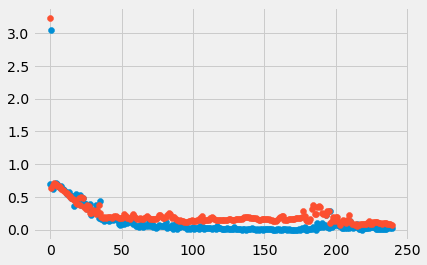

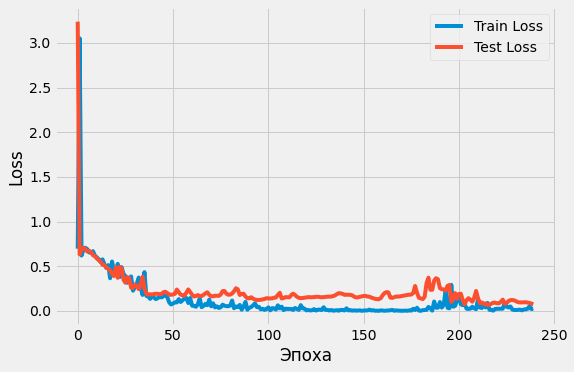

In [0]:
plt.scatter(range(len(train_losses)), train_losses)
plt.scatter(range(len(test_losses)), test_losses)

def plotTrainTestLosses(train_losses, test_losses):
    plt.figure(figsize=(8,12))
    plt.subplot(2,1,1)
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
    plt.legend()
    plt.show()
plotTrainTestLosses(train_losses, test_losses)

In [0]:
X_test, y_test = map(np.stack, zip(*testset))
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

Напишем функцию вычисления accuracy score

In [0]:
import torch.nn.functional as F

In [0]:
def test_accuracy(model, X_test, y_test):
  model.eval()

  with torch.no_grad():
    y_pred_all = []
    y_test_all = []
    for i in tqdm_notebook(range(len(y_test))):
      X_i = X_test[i].unsqueeze(0)
      y_i = y_test[i]
      y_pred = F.softmax(model(X_i), dim=1).argmax()
      y_pred_all.append(y_pred)
      y_test_all.append(y_i)

  return accuracy_score(y_test_all, y_pred_all)

Вычисляем скор на тестовых данных

In [0]:
test_accuracy(model, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0.9833333333333333

Повторил архитектуру сети с семинара.
Установил размер батча, равный 128.
Скор получился 0.613

Попробовал увеличить размер батча до 256.
Скор остался тем же.

Изменил оптимайзер с SGD на Adam.
Скор резко вырос до 0.983

Оказалось достаточно сменить оптимизатор.

**Задание 2**

---



Напишем функцию добавления шума в данные для аугментаций

In [0]:
def spoil_with_noise(data, noise_factor=0.02):
    noise = np.random.normal(size=len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [0]:
test_wav = person_1.sentence_by_index(0).raw_audio

In [0]:
IPython.display.Audio(person_1.sentence_by_index(0).raw_audio, rate=16000)

In [0]:
IPython.display.Audio(spoil_with_noise(person_1.sentence_by_index(0).raw_audio), rate=16000)

Функция для создания датасета с шумом

In [0]:
def spoil_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(spoil_with_noise(person.sentence_by_index(i).raw_audio),target))
  return spectrograms_and_targets

Добавляем шум к тестовым данным и вычисляем скор

In [0]:
testset_ = spoil_dataset('test')
X_test_, y_test_ = map(np.stack, zip(*testset_))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
X_test_ = torch.FloatTensor(X_test_)
y_test_ = torch.LongTensor(y_test_)

In [0]:
test_accuracy(model, X_test_, y_test_)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0.7173333333333334

Создадим функцию для изменения скорости аудио

In [0]:
def speed_change(data, speed_factor=0.5):
  return librosa.effects.time_stretch(data, speed_factor)

In [0]:
def spoil_dataset1(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(speed_change(person.sentence_by_index(i).raw_audio),target))
  return spectrograms_and_targets

Создадим датасет с применением изменения исходной скорости к тестовым данным и посмотрим изменение скора 

In [0]:
testset_s = spoil_dataset1('test')
X_test_s, y_test_s = map(np.stack, zip(*testset_s))
X_test_s = torch.FloatTensor(X_test_s)
y_test_s = torch.LongTensor(y_test_s)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
test_accuracy(model, X_test_s, y_test_s)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0.968

Напишем функцию изменения высоты тона

In [0]:
# def pitch_change(data, sampling_rate, pitch_factor, bins_per_octave):
#   return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor, bins_per_octave)

In [0]:
def pitch_change(data, sampling_rate, pitch_factor):
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [0]:
IPython.display.Audio(pitch_change(person_1.sentence_by_index(0).raw_audio, 16000, -6), rate=16000)

In [0]:
def spoil_dataset2(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(pitch_change(person.sentence_by_index(i).raw_audio, 16000, -6),target))
  return spectrograms_and_targets

Создадим тестовый датасет с изменением высоты тона и посмотрим скор

In [0]:
testset_p = spoil_dataset2('test')
X_test_p, y_test_p = map(np.stack, zip(*testset_p))
X_test_p = torch.FloatTensor(X_test_p)
y_test_p = torch.LongTensor(y_test_p)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
test_accuracy(model, X_test_p, y_test_p)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0.71

**Задание 3**

---


Возьмем аугментации типа "добавить шум" и дополним train и test этими данными

In [0]:
def spoil_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(spoil_with_noise(person.sentence_by_index(i).raw_audio),target))
  return spectrograms_and_targets

In [0]:
trainset = create_dataset('train')
testset = create_dataset('test')
trainset_aug = spoil_dataset('train')
testset_aug = spoil_dataset('test')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Добавим испорченные данные и перемешаем выборки

In [0]:
trainset_ext = np.random.permutation(trainset + trainset_aug)
testset_ext = np.random.permutation(testset + testset_aug)

Разобьем трейнсет на трейн и валидоционные части

In [0]:
X_ext, y_ext = map(np.stack, zip(*trainset_ext))
X_train_ext, X_val_ext, y_train_ext, y_val_ext = train_test_split(X_ext, y_ext, random_state=42)

X_train_ext = torch.FloatTensor(X_train_ext)
y_train_ext = torch.LongTensor(y_train_ext)
X_val_ext = torch.FloatTensor(X_val_ext)
y_val_ext = torch.LongTensor(y_val_ext)

In [0]:
y_train_ext.shape

torch.Size([6000])

Дополним исходную сеть дополнительным сверточным слоем и применим нормализацию и регуляризацию

In [0]:
class AudioClass_aug(nn.Module):
  def __init__(self, input_channel = 128):
    super(AudioClass_aug, self).__init__()
    self.conv1 = nn.Conv1d(128, 16, 4)
    self.bn1 = nn.BatchNorm1d(16)
    self.dp1 = nn.Dropout(0.5)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.AdaptiveAvgPool1d(64)
    self.conv2 = nn.Conv1d(16, 32, 4)
    self.bn2 = nn.BatchNorm1d(32)
    self.dp2 = nn.Dropout(0.5)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.AdaptiveAvgPool1d(64)
    self.conv3 = nn.Conv1d(32, 64, 4)
    self.bn3 = nn.BatchNorm1d(64)
    self.dp3 = nn.Dropout(0.5)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.AdaptiveAvgPool1d(64)
    self.conv4 = nn.Conv1d(64, 128, 4)
    self.bn4 = nn.BatchNorm1d(128)
    self.dp4 = nn.Dropout(0.5)
    self.relu4 = nn.ReLU()
    self.pool4 = nn.AdaptiveAvgPool1d(64)
    self.linear = nn.Linear(input_channel * 64, 2)

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.dp1(x)
    x = self.relu1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.dp2(x)
    x = self.relu2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.dp3(x)
    x = self.relu3(x)
    x = self.pool3(x)
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.dp4(x)
    x = self.relu4(x)
    x = self.pool4(x)
    x = self.linear(torch.reshape(x, (inputs.shape[0], -1)))
    
    return x

In [0]:
model_aug = AudioClass_aug()

In [0]:
model_aug

AudioClass_aug(
  (conv1): Conv1d(128, 16, kernel_size=(4,), stride=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.5, inplace=False)
  (relu1): ReLU()
  (pool1): AdaptiveAvgPool1d(output_size=64)
  (conv2): Conv1d(16, 32, kernel_size=(4,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.5, inplace=False)
  (relu2): ReLU()
  (pool2): AdaptiveAvgPool1d(output_size=64)
  (conv3): Conv1d(32, 64, kernel_size=(4,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp3): Dropout(p=0.5, inplace=False)
  (relu3): ReLU()
  (pool3): AdaptiveAvgPool1d(output_size=64)
  (conv4): Conv1d(64, 128, kernel_size=(4,), stride=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp4): Dropout(p=0.5, inplace=False)
  (relu4): ReLU()
  (pool4): AdaptiveAvgPool1d(outpu

Уменьшим шаг обучения

In [0]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.AdamW(model_aug.parameters(), lr = learning_rate)

Подготовим данные для Loader'a и обучим сеть

In [0]:
dataset_ext = TensorDataset(X_train_ext, y_train_ext)

In [0]:
def train(num_epoch):
    train_losses_ext = []
    test_losses_ext = []
    for _ in tqdm_notebook(range(num_epoch)):
      for X_train_ext, y_train_ext in DataLoader(dataset_ext, 512):
        model_aug.train(True)
        y_pred_ext = model_aug(X_train_ext)
        loss_ext = loss_fn(y_pred_ext, y_train_ext)
        optimizer.zero_grad()
        loss_ext.backward()
        optimizer.step()
        train_losses_ext.append(loss_ext.item())
        model_aug.train(False)
        test_losses_ext.append(loss_fn(model_aug(X_val_ext), y_val_ext).item())

    return train_losses_ext, test_losses_ext

In [0]:
train_losses_ext, test_losses_ext = train(30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Посмотрим лоссы

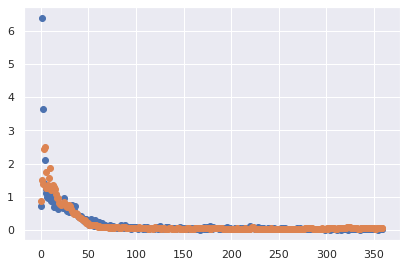

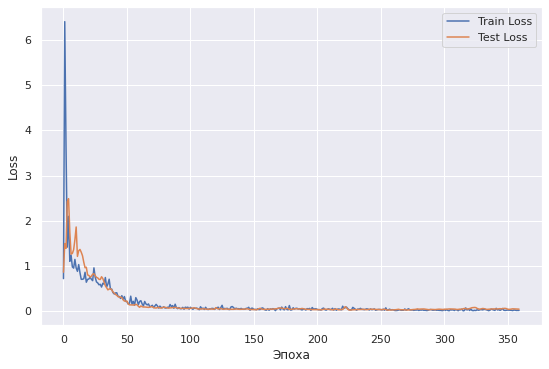

In [0]:
plt.scatter(range(len(train_losses_ext)), train_losses_ext)
plt.scatter(range(len(test_losses_ext)), test_losses_ext)

def plotTrainTestLosses(train_losses_ext, test_losses_ext):
    plt.figure(figsize=(8,12))
    plt.subplot(2,1,1)
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.plot(range(len(train_losses_ext)), train_losses_ext, label='Train Loss')
    plt.plot(range(len(test_losses_ext)), test_losses_ext, label='Test Loss')
    plt.legend()
    plt.show()
plotTrainTestLosses(train_losses_ext, test_losses_ext)

In [0]:
X_test_ext, y_test_ext = map(np.stack, zip(*testset_ext))
X_test_ext = torch.FloatTensor(X_test_ext)
y_test_ext = torch.LongTensor(y_test_ext)

In [0]:
def test_accuracy_aug(model_aug, X_test_ext, y_test_ext):
  model_aug.eval()

  with torch.no_grad():
    y_pred_all = []
    y_test_all = []
    for i in tqdm_notebook(range(len(y_test_ext))):
      X_i = X_test_ext[i].unsqueeze(0)
      y_i = y_test_ext[i]
      y_pred = F.softmax(model_aug(X_i), dim=1).argmax()
      y_pred_all.append(y_pred)
      y_test_all.append(y_i)

  return accuracy_score(y_test_all, y_pred_all)

Вычислим скор на смешанных данных

In [0]:
test_accuracy_aug(model_aug, X_test_ext, y_test_ext)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0.974

Аугментации пробовал разного типа, самые действенные - добавление шума и изменения тона. Изменение скорости сыграло небольшую роль в уменьшении скора, может стоило фактор изменить. Но применения одного только шума было достаточно, чтобы уменьшить скор до 0.71, поэтому остановился на этом.

Сначала попробовал увеличивать размер батча, но особого влияния на скор это не оказывало.

Решил изменить архитектуру сети. Т.к. более вероятным, в плане воздействия на скор, посчитал применение регуляризации (Dropout) и нормализации (Batchnorm), а также пулинга (для уменьшения вероятности переобучения), то и решил сразу написать сеть со всем этим. Также уменьшил шаг обучения с 0.01 до 0.001, т.к. посчитал, что сейчас данные "неоднородные" и уменьшение lr поможет достичь сходимости быстрее.

Как оказалось этого было вполне достаточно, чтобы вернуть скор с 0.71 до 0.974.